In [ ]:
import pandas as pd
import numpy as np

import json
import html
import codecs

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit

from copy import deepcopy

In [ ]:
!pip install pytorchltr
from pytorchltr.evaluation import ndcg

In [ ]:
!pip install catboost
from catboost import CatBoostRanker, Pool, MetricVisualizer

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = './drive/MyDrive/Colab Notebooks/Hackathon/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CatBoost (features + text)

## Load data

In [ ]:
with codecs.open(f'{data_dir}/ranking_train.jsonl', encoding='utf-8', mode='r') as f:
    lines = f.readlines()
    q_ds_list = [json.loads(line) for line in lines]

In [ ]:
query = []
documents = []
scores = []
for q_ds in q_ds_list:
    query.append(html.unescape(q_ds['text']))
    ds = [com['text'] for com in q_ds['comments']]
    for com in q_ds['comments']:
        documents.append(html.unescape(com['text']))
        scores.append(com['score'])

scores = (4 - np.array(scores))
torch.save(torch.Tensor(scores), f'{data_dir}/scores.pt')

In [ ]:
features_df = pd.read_csv(f'{data_dir}/features.csv', index_col=0)
query_series = pd.Series(query).repeat(5).reset_index(drop=True)
document_series = pd.Series(documents)
features_df['query_text'] = query_series
features_df['document_text'] = document_series
features_df.head()

,chars_num,cap_chars_num,digits_num,words_num,cap_words_num,unique_words_num,sentences_num,http_num,unique_vs_words,avg_wordlength,avg_sentencelength,ARI,polarity,subjectivity,query_cos_sim,query_text,document_text
0,998,12,2,181,0,120,12,0,0.662983,5.513812,15.083333,12.081722,-0.042308,0.447436,0.650387,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...
1,414,4,0,76,0,61,4,0,0.802632,5.447368,19.000000,13.727105,0.172222,0.325000,0.521176,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...
2,488,28,0,91,5,71,6,0,0.780220,5.362637,15.166667,11.411355,0.190303,0.408788,0.388382,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...
3,318,7,2,64,2,48,4,0,0.750000,4.968750,16.000000,9.972812,0.176190,0.509524,0.432402,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...
4,81,1,0,14,1,13,1,0,0.928571,5.785714,14.000000,12.820714,0.000000,0.000000,0.558688,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...


In [ ]:
groups_ids = np.arange(len(features_df)//5).repeat(5)
groups_ids.shape, groups_ids

((440535,), array([    0,     0,     0, ..., 88106, 88106, 88106]))

## Split data and train model

In [ ]:
splitter = GroupShuffleSplit(test_size=0.20, n_splits=2, random_state=42)
split = splitter.split(features_df, groups=groups_ids)

train_inds, test_inds = next(split)
train_df = features_df.iloc[train_inds]
train_group_ids = groups_ids[train_inds]
train_scores = scores[train_inds]
test_df = features_df.iloc[test_inds]
test_group_ids = groups_ids[test_inds]
test_scores = scores[test_inds]

In [ ]:
train = Pool(
    data=train_df,
    label=train_scores,
    group_id=train_group_ids,
    text_features=['document_text', 'query_text'],
)

test = Pool(
    data=test_df,
    label=test_scores,
    group_id=test_group_ids,
    text_features=['document_text', 'query_text'],
)

In [ ]:
default_parameters = {
    'iterations': 50,
    'custom_metric': ['NDCG'],
    'verbose': True,
    'random_seed': 0,
}

def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)

    return model

In [ ]:
model = fit_model('YetiRank', {'metric_period': 10, 'learning_rate': 0.01,
                               'depth': 4})  # 'task_type': 'GPU'

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8357607	best: 0.8357607 (0)	total: 4.99s	remaining: 4m 4s
10:	test: 0.8693005	best: 0.8693005 (10)	total: 24.7s	remaining: 1m 27s
20:	test: 0.8790809	best: 0.8790809 (20)	total: 45.6s	remaining: 1m 2s
30:	test: 0.8822367	best: 0.8822367 (30)	total: 1m 12s	remaining: 44.1s
40:	test: 0.8847914	best: 0.8847914 (40)	total: 1m 34s	remaining: 20.8s
49:	test: 0.8877576	best: 0.8877576 (49)	total: 1m 58s	remaining: 0us

bestTest = 0.887757583
bestIteration = 49



In [ ]:
# NDCG on test
n = torch.tensor([5])
s = torch.tensor(model.predict(test).reshape([len(test_df)//5, 5]))
r = torch.tensor(test_scores.reshape([len(test_df)//5, 5]))
ndcgs_test = ndcg(s, r, n, k=5).numpy()
ndcgs_test.mean()

0.83220065

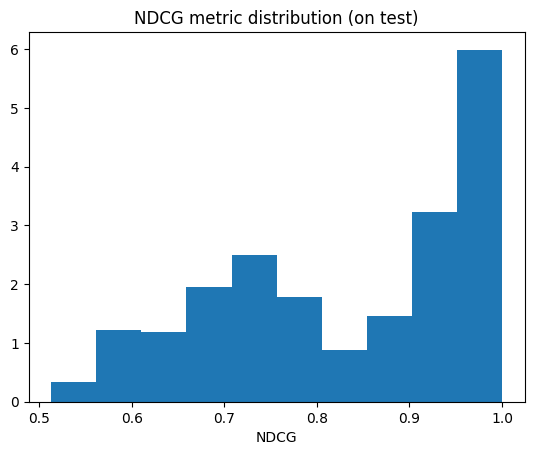

In [ ]:
plt.hist(ndcgs_test, bins=10, density=True)
plt.title("NDCG metric distribution (on test)")
plt.xlabel("NDCG")
plt.show()

We can observe that on part of the test sample, the NDCG metric has a high value (>0.85), and on the other part, the ranking is almost random (a dome around ~0.72).

An idea: train the classifier to divide the input data into two classes (, ).  
*   data from the 1st class get high value of NDCG with the developped model
*   data fromthe 2nd class cannot be ranked with the developped model (low NDCG)

Next, we need to train the developped ranking model only on the 1st class of data, and then build a new model for the 2nd class and train it only on the data of the 2nd class.

1.   data -> [classifier] -> class
2.   (data + class) -> [ranking model] -> ordered comments


In [ ]:
# NDCG on train
n = torch.tensor([5])
s = torch.tensor(model.predict(train).reshape([len(train_df)//5, 5]))
r = torch.tensor(train_scores.reshape([len(train_df)//5, 5]))
ndcgs_train = ndcg(s, r, n, k=5).numpy()
ndcgs_train.mean()

0.8326671

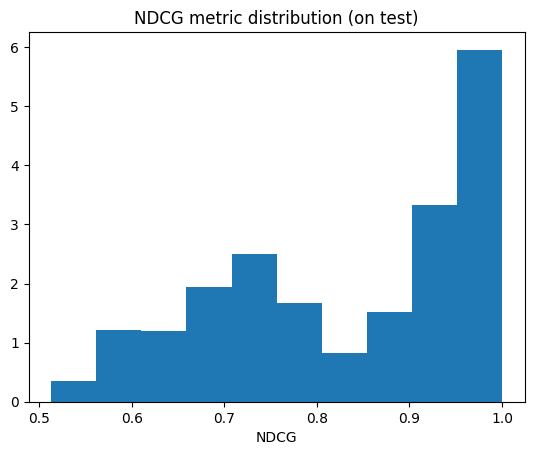

In [ ]:
plt.hist(ndcgs_train, bins=10, density=True)
plt.title("NDCG metric distribution (on train)")
plt.xlabel("NDCG")
plt.show()

In [ ]:
# NDCG in case of random ranking
sumscore = 0
yinit = np.array(range(5))
np.random.seed(42)
for i in range(10000):
    y = np.array(yinit)
    np.random.shuffle(y)
    sumscore += ndcg( torch.FloatTensor([yinit]), torch.tensor([y]), n, k=5)
sumscore/10000

tensor([0.7184])

In [ ]:
# NDCG in case of ideal ranking
y = np.array(range(5))
ndcg( torch.FloatTensor([y]), torch.tensor([y]), n, k=5)

tensor([1.])

In [ ]:
# NDCG in case of ideal reversed ranking
y_rev = y - 5
ndcg( torch.FloatTensor([y_rev]), torch.tensor([y]), n, k=5)

tensor([1.])

# CatBoost (features + embeddings)

## Load data

In [ ]:
features_df = pd.read_csv(f'{data_dir}/features.csv', index_col=0)
features_df.head()

,chars_num,cap_chars_num,digits_num,words_num,cap_words_num,unique_words_num,sentences_num,http_num,unique_vs_words,avg_wordlength,avg_sentencelength,ARI,polarity,subjectivity,query_cos_sim
0,998,12,2,181,0,120,12,0,0.662983,5.513812,15.083333,12.081722,-0.042308,0.447436,0.650387
1,414,4,0,76,0,61,4,0,0.802632,5.447368,19.000000,13.727105,0.172222,0.325000,0.521176
2,488,28,0,91,5,71,6,0,0.780220,5.362637,15.166667,11.411355,0.190303,0.408788,0.388382
3,318,7,2,64,2,48,4,0,0.750000,4.968750,16.000000,9.972812,0.176190,0.509524,0.432402
4,81,1,0,14,1,13,1,0,0.928571,5.785714,14.000000,12.820714,0.000000,0.000000,0.558688


In [ ]:
scores = torch.load(f'{data_dir}/scores.pt').numpy()
scores

array([4., 3., 2., ..., 2., 1., 0.], dtype=float32)

### Load BERT embeddings

In [ ]:
'''
query_embedding = torch.load(f'{data_dir}/query_embedding.pt')
documents_embedding = torch.load(f'{data_dir}/documents_embedding.pt')
scores = torch.load(f'{data_dir}/scores.pt')
'''

### Load better embeddings

In [ ]:
query_embedding = pd.Series(list(np.load(f'{data_dir}/embeddings_v2/query_embeddings_all-mpnet-base-v2.npy')))
query_embedding = query_embedding.repeat(5).reset_index(drop=True)
documents_embedding = pd.Series(list(np.load(f'{data_dir}/embeddings_v2/documents_embeddings_all-mpnet-base-v2.npy')))
features_df['query_embedding'] = query_embedding
features_df['documents_embedding'] = documents_embedding
del query_embedding, documents_embedding
features_df.head()

,chars_num,cap_chars_num,digits_num,words_num,cap_words_num,unique_words_num,sentences_num,http_num,unique_vs_words,avg_wordlength,avg_sentencelength,ARI,polarity,subjectivity,query_cos_sim,query_embedding,documents_embedding
0,998,12,2,181,0,120,12,0,0.662983,5.513812,15.083333,12.081722,-0.042308,0.447436,0.650387,"[0.006199492, 0.06803588, 0.033932466, -0.0389...","[0.02874059, 0.074416034, 0.00049099687, -0.06..."
1,414,4,0,76,0,61,4,0,0.802632,5.447368,19.000000,13.727105,0.172222,0.325000,0.521176,"[0.006199492, 0.06803588, 0.033932466, -0.0389...","[0.024375303, 0.07518393, 0.00220382, -0.02227..."
2,488,28,0,91,5,71,6,0,0.780220,5.362637,15.166667,11.411355,0.190303,0.408788,0.388382,"[0.006199492, 0.06803588, 0.033932466, -0.0389...","[0.041326154, 0.033660267, -0.0032435376, -0.0..."
3,318,7,2,64,2,48,4,0,0.750000,4.968750,16.000000,9.972812,0.176190,0.509524,0.432402,"[0.006199492, 0.06803588, 0.033932466, -0.0389...","[0.045692235, 0.03450061, 0.02756351, -0.04389..."
4,81,1,0,14,1,13,1,0,0.928571,5.785714,14.000000,12.820714,0.000000,0.000000,0.558688,"[0.006199492, 0.06803588, 0.033932466, -0.0389...","[0.015234432, 0.09494876, 0.013694247, -0.0326..."


## Split data and train model

In [ ]:
splitter = GroupShuffleSplit(test_size=0.20, n_splits=2, random_state=42)
split = splitter.split(features_df, groups=groups_ids)

train_inds, test_inds = next(split)
train_df = features_df.iloc[train_inds]
train_group_ids = groups_ids[train_inds]
train_scores = scores[train_inds]
test_df = features_df.iloc[test_inds]
test_group_ids = groups_ids[test_inds]
test_scores = scores[test_inds]

In [ ]:
train = Pool(
    data=train_df,
    label=train_scores,
    group_id=train_group_ids,
    embedding_features=['documents_embedding', 'query_embedding'],
)

test = Pool(
    data=test_df,
    label=test_scores,
    group_id=test_group_ids,
    embedding_features=['documents_embedding', 'query_embedding'],
)

In [ ]:
default_parameters = {
    'iterations': 50,
    'custom_metric': ['NDCG'],
    'verbose': True,
    'random_seed': 0,
}

def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)

    return model

In [ ]:
model = fit_model('YetiRank', {'metric_period': 10, 'learning_rate': 0.01,
                               'depth': 4})  # 'task_type': 'GPU'

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8364405	best: 0.8364405 (0)	total: 521ms	remaining: 25.5s
10:	test: 0.8673998	best: 0.8673998 (10)	total: 6.72s	remaining: 23.8s
20:	test: 0.8747770	best: 0.8747770 (20)	total: 10.9s	remaining: 15.1s
30:	test: 0.8823703	best: 0.8823703 (30)	total: 15.2s	remaining: 9.29s
40:	test: 0.8841149	best: 0.8841149 (40)	total: 21.3s	remaining: 4.68s
49:	test: 0.8863856	best: 0.8863856 (49)	total: 25.1s	remaining: 0us

bestTest = 0.8863855624
bestIteration = 49



In [ ]:
# NDCG on test
n = torch.tensor([5])
s = torch.tensor(model.predict(test).reshape([len(test_df)//5, 5]))
r = torch.tensor(test_scores.reshape([len(test_df)//5, 5]))
ndcgs_test = ndcg(s, r, n, k=5).numpy()
ndcgs_test.mean()

0.82961476

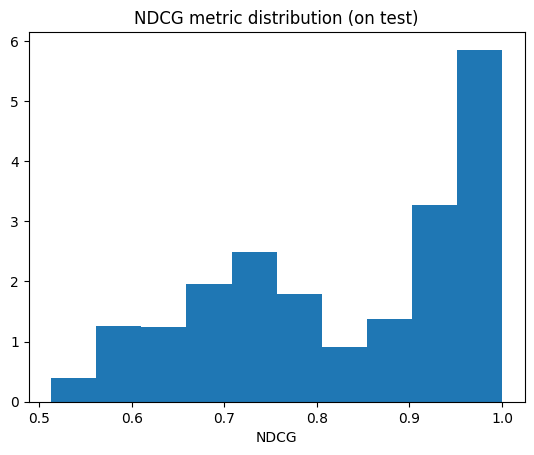

In [ ]:
plt.hist(ndcgs_test, bins=10, density=True)
plt.title("NDCG metric distribution (on test)")
plt.xlabel("NDCG")
plt.show()

In [ ]:
# NDCG on train
n = torch.tensor([5])
s = torch.tensor(model.predict(train).reshape([len(train_df)//5, 5]))
r = torch.tensor(train_scores.reshape([len(train_df)//5, 5]))
ndcgs_train = ndcg(s, r, n, k=5).numpy()
ndcgs_train.mean()

0.83673495

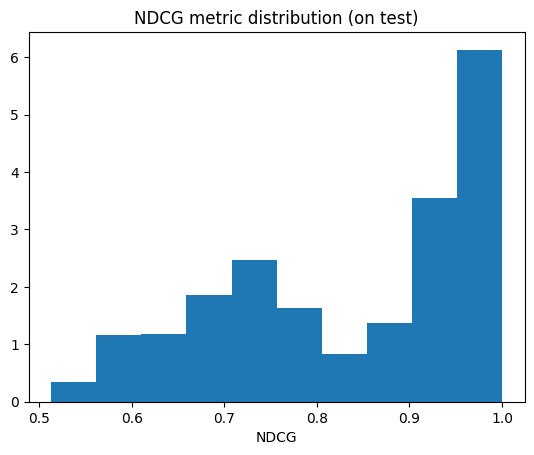

In [ ]:
plt.hist(ndcgs_train, bins=10, density=True)
plt.title("NDCG metric distribution (on test)")
plt.xlabel("NDCG")
plt.show()